In [1]:
!pip install xhistogram==0.3.0

  Using cached xhistogram-0.3.0-py3-none-any.whl (19 kB)
  Attempting uninstall: xhistogram
    Found existing installation: xhistogram 0.1.2
    Uninstalling xhistogram-0.1.2:
      Successfully uninstalled xhistogram-0.1.2


In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:43333")
client

Client Scheduler: tcp://127.0.0.1:43333 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 64 Memory: 270.48 GB


In [3]:
client.restart()

Client Scheduler: tcp://127.0.0.1:38605 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 64 Memory: 270.48 GB


In [3]:
import numpy as np
import xarray as xr
import pandas as pd
from xhistogram.xarray import histogram as xhist
from dask.diagnostics import ProgressBar
from xgcm.grid import Grid
import xrft
import gsw
import s3fs
import matplotlib.colors as clr
import matplotlib.pyplot as plt
plt.rcParams['pcolor.shading'] = 'auto'
%matplotlib inline

In [15]:
import os
import gcsfs

gcs = gcsfs.GCSFileSystem(requester_pays=True)

SCRATCH = os.environ['SCRATCH_BUCKET']
SCRATCH

'gcs://meom-ige-scratch/roxyboy'

# Load data

In [4]:
endpoint_url = 'https://ncsa.osn.xsede.org'
fs_osn = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': endpoint_url},)

url = "s3://Pangeo/pangeo-forge/swot_adac/eNATL60/"
enatl60_datasets = {
    ds: xr.open_zarr(fs_osn.get_mapper(f"{url}{ds}.zarr"), consolidated=True)
    for ds in ["Region02/surface_hourly/fma","Region02/surface_hourly/aso"]
}
enatl60_datasets

{'Region02/surface_hourly/fma': <xarray.Dataset>
 Dimensions:        (time_counter: 2136, x: 607, y: 735)
 Coordinates:
     depth          (y, x) float32 dask.array<chunksize=(735, 607), meta=np.ndarray>
     e1f            (y, x) float64 dask.array<chunksize=(735, 607), meta=np.ndarray>
     e1t            (y, x) float64 dask.array<chunksize=(735, 607), meta=np.ndarray>
     e1u            (y, x) float64 dask.array<chunksize=(735, 607), meta=np.ndarray>
     e1v            (y, x) float64 dask.array<chunksize=(735, 607), meta=np.ndarray>
     e2f            (y, x) float64 dask.array<chunksize=(735, 607), meta=np.ndarray>
     e2t            (y, x) float64 dask.array<chunksize=(735, 607), meta=np.ndarray>
     e2u            (y, x) float64 dask.array<chunksize=(735, 607), meta=np.ndarray>
     e2v            (y, x) float64 dask.array<chunksize=(735, 607), meta=np.ndarray>
     lat            (y, x) float32 dask.array<chunksize=(735, 607), meta=np.ndarray>
     lon            (y, x) flo

In [5]:
endpoint_url = 'https://ncsa.osn.xsede.org'
fs_osn = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': endpoint_url},)

url = "s3://Pangeo/pangeo-forge/swot_adac/HYCOM50/"
hycom50_datasets = {
    ds: xr.open_zarr(fs_osn.get_mapper(f"{url}{ds}.zarr"), consolidated=True, decode_times=False)
    for ds in ["Region02_GE/surf/fma","Region02_GE/surf/aso"]
}
hycom50_datasets

{'Region02_GE/surf/fma': <xarray.Dataset>
 Dimensions:    (lat: 615, lon: 503, time: 2160)
 Coordinates:
   * time       (time) int64 0 1 2 3 4 5 6 ... 2153 2154 2155 2156 2157 2158 2159
 Dimensions without coordinates: lat, lon
 Data variables:
     latitude   (lat) float32 dask.array<chunksize=(615,), meta=np.ndarray>
     longitude  (lon) float32 dask.array<chunksize=(503,), meta=np.ndarray>
     ssh        (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
     sss        (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
     sst        (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
     tauewd     (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
     taunwd     (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
     uu1        (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
     vv1        (time, lat, lon)

In [6]:
winter = np.concatenate((np.concatenate((np.repeat(2,696),
                                         np.repeat(3,744))),
                         np.repeat(4,720)))
summer = np.concatenate((np.concatenate((np.repeat(8,744),
                                         np.repeat(9,720))),
                         np.repeat(10,744)))
summer

array([ 8,  8,  8, ..., 10, 10, 10])

In [6]:
endpoint_url = 'https://ncsa.osn.xsede.org'
fs_osn = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': endpoint_url},)

url = "s3://Pangeo/pangeo-forge/swot_adac/HYCOM50/"
hycom50_grids = {
    grid: xr.open_zarr(fs_osn.get_mapper(f"{url}{grid}.zarr"), consolidated=True)
    for grid in ["grid_02"]
}

hycom50_grids

{'grid_02': <xarray.Dataset>
 Dimensions:    (lat: 615, lon: 503)
 Dimensions without coordinates: lat, lon
 Data variables:
     depth      (lat, lon) float64 dask.array<chunksize=(615, 503), meta=np.ndarray>
     latitude   (lat) float64 dask.array<chunksize=(615,), meta=np.ndarray>
     longitude  (lon) float64 dask.array<chunksize=(503,), meta=np.ndarray>}

In [7]:
# Functions to adapt croco outputs to xgcm
##########################################

def adjust_coords(ds):

    if 'nav_lon_u' not in ds.coords:
        ##########################
        # for regular CROCO files:
        ds = ds.set_coords([c for c in ds.variables if 'lon' in c or 'lat' in c ])

    else:
        ##########################
        # for XIOS files:
        
        ds = ds.rename({'time_counter': 'time'})
        
        ds = ds.reset_coords([c for c in ds.coords if 'nav' in c])

        # rename redundant dimensions
        _dims = (d for d in ['x_v', 'y_u', 'x_w', 'y_w'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: d[0]+'_rho'})

        # change axis names to xi,eta (instead of x,y)
        _dims = (d for d in ['x_u', 'x_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'xi' + d[1:]}) 

        _dims = (d for d in ['y_v', 'y_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'eta' + d[1:]}) 


        # change nav variables to coordinates        
        _coords = [d for d in [d for d in ds.data_vars.keys()] if "nav_" in d]
        ds = ds.set_coords(_coords) 

        # rename coordinates 
        eta_suff={}
        for c in ds.coords:
            new_c = c.replace('nav_lat','lat').replace('nav_lon','lon')
            ds = ds.rename({c:new_c})
            # reset names and units
            ds[new_c] = (ds[new_c].assign_attrs(units='deg', 
                                               standard_name=new_c,
                                               long_name=new_c)
                        )

    ##########################
    # For all types  
    if 'eta_psi' in ds.dims: ds = ds.rename({'eta_psi': 'eta_v'}) 
    if 'xi_psi' in ds.dims: ds = ds.rename({'xi_psi': 'xi_u'}) 
        

    ##########################
    # Create xgcm grid
    coords={'xi':{'center':'xi_rho', 'inner':'xi_u'}, 
            'eta':{'center':'eta_rho', 'inner':'eta_v'}, 
            's':{'center':'s_rho', 'outer':'s_w'}}

    ds.attrs['xgcm-Grid'] = Grid(ds, coords=coords, periodic=[])


    return ds

    
def add_grd(ds,grd):
    
    ##########################
    for variable in grd.data_vars.keys():
        #print(variable)
        ds[variable] = grd[variable]
        
    ds['mask_rho'] = ds.mask_rho.where(ds.mask_rho>0,np.nan)
    
    if 'lon_psi' not in ds.coords: 
        #ds['lon_psi'] = grd['lon_psi']
        #ds['lat_psi'] = grd['lat_psi']
        ds = ds.assign_coords({'lon_psi':grd['lon_psi'], 'lat_psi':grd['lat_psi']})

    return ds
 
    ########
    
    
endpoint_url = 'https://ncsa.osn.xsede.org'
fs_osn = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': endpoint_url},)

url = "s3://Pangeo/pangeo-forge/swot_adac/GIGATL/"
gigatl_datasets = {
    ds: adjust_coords(xr.open_zarr(fs_osn.get_mapper(f"{url}{ds}.zarr"), consolidated=True))
    for ds in ["Region02/surf/fma", "Region02/surf/aso"]
}

gigatl_datasets

{'Region02/surf/fma': <xarray.Dataset>
 Dimensions:     (eta_rho: 1411, eta_v: 1410, time: 2280, xi_rho: 1331, xi_u: 1330)
 Coordinates:
     lat         (eta_rho, xi_rho) float32 dask.array<chunksize=(1411, 1331), meta=np.ndarray>
     lon         (eta_rho, xi_rho) float32 dask.array<chunksize=(1411, 1331), meta=np.ndarray>
 Dimensions without coordinates: eta_rho, eta_v, time, xi_rho, xi_u
 Data variables:
     angle       (eta_rho, xi_rho) float32 dask.array<chunksize=(1411, 1331), meta=np.ndarray>
     f           (eta_rho, xi_rho) float32 dask.array<chunksize=(1411, 1331), meta=np.ndarray>
     h           (eta_rho, xi_rho) float32 dask.array<chunksize=(1411, 1331), meta=np.ndarray>
     ocean_time  (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
     pm          (eta_rho, xi_rho) float32 dask.array<chunksize=(1411, 1331), meta=np.ndarray>
     pn          (eta_rho, xi_rho) float32 dask.array<chunksize=(1411, 1331), meta=np.ndarray>
     salt        (time, eta_rho, xi_

In [8]:
from xmitgcm import llcreader
model = llcreader.ECCOPortalLLC2160Model()
print(model.varnames)

['Eta', 'KPPhbl', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSflux', 'oceTAUX', 'oceTAUY', 'PhiBot', 'Salt', 'SIarea', 'SIheff', 'SIhsalt', 'SIhsnow', 'SIuice', 'SIvice', 'Theta', 'U', 'V', 'W']


In [9]:
llc02w = model.get_dataset(varnames=['U','V'], k_levels=[0], 
                           type='latlon').sel(time=slice('2012-02-01','2012-04-30'),
                                              j=slice(4778,5098),j_g=slice(4778,5098),
                                              i=slice(8255,8496),i_g=slice(8255,8496))
llc02w

<xarray.Dataset>
Dimensions:  (face: 13, i: 242, i_g: 242, j: 321, j_g: 321, k: 1, k_l: 1, k_p1: 2, k_u: 1, time: 2160)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 8255 8256 8257 8258 8259 ... 8492 8493 8494 8495 8496
  * i_g      (i_g) int64 8255 8256 8257 8258 8259 ... 8492 8493 8494 8495 8496
  * j        (j) int64 4778 4779 4780 4781 4782 ... 5094 5095 5096 5097 5098
  * j_g      (j_g) int64 4778 4779 4780 4781 4782 ... 5094 5095 5096 5097 5098
  * k        (k) int64 0
  * k_u      (k_u) int64 0
  * k_l      (k_l) int64 0
  * k_p1     (k_p1) int64 0 1
  * time     (time) datetime64[ns] 2012-02-01 ... 2012-04-30T23:00:00
    CS       (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    drC      (k_p1) >f4 dask.array<chunksize=(2,), meta=np.ndarray>
    drF      (k) >f4 dask.array<chunksize=(1,), meta=np.ndarray>
    dxC      (j, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    dxF      (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    dxG      (j_g, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    dyC      (j_g, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    dyF      (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    dyG      (j, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    hFacC    (k, j, i) float32 dask.array<chunksize=(1, 321, 242), meta=np.ndarray>
    hFacS    (k, j_g, i) float32 dask.array<chunksize=(1, 321, 242), meta=np.ndarray>
    hFacW    (k, j, i_g) float32 dask.array<chunksize=(1, 321, 242), meta=np.ndarray>
    PHrefC   (k) >f4 dask.array<chunksize=(1,), meta=np.ndarray>
    PHrefF   (k_p1) >f4 dask.array<chunksize=(2,), meta=np.ndarray>
    rA       (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    rAs      (j_g, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    rAw      (j, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    Z        (k) >f4 dask.array<chunksize=(1,), meta=np.ndarray>
    Zp1      (k_p1) >f4 dask.array<chunksize=(2,), meta=np.ndarray>
    rhoRef   (k) >f4 dask.array<chunksize=(1,), meta=np.ndarray>
    rLowC    (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    rLowS    (j_g, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    rLowW    (j, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    rSurfC   (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    rSurfS   (j_g, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    rSurfW   (j, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    rAz      (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    XG       (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    YG       (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    dxV      (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    dyU      (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    Zl       (k_l) >f4 dask.array<chunksize=(1,), meta=np.ndarray>
    Zu       (k_u) >f4 dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    U        (time, k, j, i_g) float32 dask.array<chunksize=(1, 1, 321, 242), meta=np.ndarray>
    V        (time, k, j_g, i) float32 dask.array<chunksize=(1, 1, 321, 242), meta=np.ndarray>

In [10]:
llc02s = model.get_dataset(varnames=['U','V'], k_levels=[0], 
                           type='latlon').sel(time=slice('2011-08-01','2011-10-31'),
                                              j=slice(4778,5098),j_g=slice(4778,5098),
                                              i=slice(8255,8496),i_g=slice(8255,8496))
llc02s

<xarray.Dataset>
Dimensions:  (face: 13, i: 242, i_g: 242, j: 321, j_g: 321, k: 1, k_l: 1, k_p1: 2, k_u: 1, time: 2208)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 8255 8256 8257 8258 8259 ... 8492 8493 8494 8495 8496
  * i_g      (i_g) int64 8255 8256 8257 8258 8259 ... 8492 8493 8494 8495 8496
  * j        (j) int64 4778 4779 4780 4781 4782 ... 5094 5095 5096 5097 5098
  * j_g      (j_g) int64 4778 4779 4780 4781 4782 ... 5094 5095 5096 5097 5098
  * k        (k) int64 0
  * k_u      (k_u) int64 0
  * k_l      (k_l) int64 0
  * k_p1     (k_p1) int64 0 1
  * time     (time) datetime64[ns] 2011-08-01 ... 2011-10-31T23:00:00
    CS       (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    drC      (k_p1) >f4 dask.array<chunksize=(2,), meta=np.ndarray>
    drF      (k) >f4 dask.array<chunksize=(1,), meta=np.ndarray>
    dxC      (j, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    dxF      (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    dxG      (j_g, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    dyC      (j_g, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    dyF      (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    dyG      (j, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    hFacC    (k, j, i) float32 dask.array<chunksize=(1, 321, 242), meta=np.ndarray>
    hFacS    (k, j_g, i) float32 dask.array<chunksize=(1, 321, 242), meta=np.ndarray>
    hFacW    (k, j, i_g) float32 dask.array<chunksize=(1, 321, 242), meta=np.ndarray>
    PHrefC   (k) >f4 dask.array<chunksize=(1,), meta=np.ndarray>
    PHrefF   (k_p1) >f4 dask.array<chunksize=(2,), meta=np.ndarray>
    rA       (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    rAs      (j_g, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    rAw      (j, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    Z        (k) >f4 dask.array<chunksize=(1,), meta=np.ndarray>
    Zp1      (k_p1) >f4 dask.array<chunksize=(2,), meta=np.ndarray>
    rhoRef   (k) >f4 dask.array<chunksize=(1,), meta=np.ndarray>
    rLowC    (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    rLowS    (j_g, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    rLowW    (j, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    rSurfC   (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    rSurfS   (j_g, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    rSurfW   (j, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    rAz      (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    XG       (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    YG       (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    dxV      (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    dyU      (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    Zl       (k_l) >f4 dask.array<chunksize=(1,), meta=np.ndarray>
    Zu       (k_u) >f4 dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    U        (time, k, j, i_g) float32 dask.array<chunksize=(1, 1, 321, 242), meta=np.ndarray>
    V        (time, k, j_g, i) float32 dask.array<chunksize=(1, 1, 321, 242), meta=np.ndarray>

In [11]:
metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
    ('Z',): ['drC'], # Z distances
    ('X', 'Y'): ['rA', 'rAs', 'rAw'] # Areas
}

gridllc = Grid(llc02w, periodic=[],
               coords={'Z':{'center':'k','outer':'k_p1'},
                       'Y':{'center':'j','left':'j_g'},
                       'X':{'center':'i','left':'i_g'}},
               metrics=metrics
              )
gridllc

<xgcm.Grid>
Z Axis (not periodic, boundary=None):
  * center   k --> outer
  * outer    k_p1 --> center
Y Axis (not periodic, boundary=None):
  * center   j --> left
  * left     j_g --> center
X Axis (not periodic, boundary=None):
  * center   i --> left
  * left     i_g --> center

In [12]:
llcfC = xr.apply_ufunc(gsw.f,llc02s.YC,dask='parallelized')
llcfG = xr.apply_ufunc(gsw.f,llc02s.YG,dask='parallelized')
llcfG

<xarray.DataArray 'YG' (j_g: 321, i_g: 242)>
dask.array<transpose, shape=(321, 242), dtype=float64, chunksize=(321, 242), chunktype=numpy.ndarray>
Coordinates:
  * i_g      (i_g) int64 8255 8256 8257 8258 8259 ... 8492 8493 8494 8495 8496
  * j_g      (j_g) int64 4778 4779 4780 4781 4782 ... 5094 5095 5096 5097 5098
    rAz      (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    XG       (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    YG       (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    dxV      (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    dyU      (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>

# Vorticity and strain

In [14]:
def diff(a, shift, axis):
    return a - np.roll(a, shift, axis)

def nemo_vort(u, v, e1f, e2f, e2v, e1u):
    return (
        diff(v * e2v, 1, axis=-1)
        - diff(u * e1u, 1, axis=-2)
    ) / (e1f  * e2f)

def nemo_str(u, v, e1t, e2t, e2u, e1v, e1f, e2f, e1u, e2v):
    str1 = (diff(u * e2u, 1, axis=-1)
            - diff(v * e1v, 1, axis=-2)
           ) / (e1t  * e2t)
    str2 = (diff(u * e1u, 1, axis=-2)
            + diff(v * e2v, 1, axis=-1)
           ) / (e1f  * e2f)
    str1 = .25*(str1 
                + np.roll(str1,1,-1) 
                + np.roll(str1,1,-2)
                + np.roll(np.roll(str1,1,-1),1,-2)
               )
    return np.sqrt(str1**2
        + str2**2
    )

In [15]:
enatl02w = enatl60_datasets["Region02/surface_hourly/fma"]

enatlf = xr.apply_ufunc(gsw.f, enatl02w.lat, dask='parallelized')

vorenatlw = xr.apply_ufunc(
    nemo_vort,
    enatl02w.sozocrtx[::12], 
    enatl02w.somecrty[::12], 
    enatl02w.e1f, enatl02w.e2f,
    enatl02w.e2v, enatl02w.e1u,
    input_core_dims = 6 * [['y', 'x']],    # 6 inputs
    output_core_dims = [['y', 'x']],
    output_dtypes=[enatl02w.sozocrtx.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('vort')
strenatlw = xr.apply_ufunc(
    nemo_str,
    enatl02w.sozocrtx[::12], 
    enatl02w.somecrty[::12], 
    enatl02w.e1t, enatl02w.e2t,
    enatl02w.e2u, enatl02w.e1v,
    enatl02w.e1f, enatl02w.e2f,
    enatl02w.e1u, enatl02w.e2v,
    input_core_dims = 10 * [['y', 'x']],   # 10 inputs
    output_core_dims = [['y', 'x']],
    output_dtypes=[enatl02w.sozocrtx.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('strain')
strenatlw

<xarray.DataArray 'strain' (time_counter: 178, y: 735, x: 607)>
dask.array<transpose, shape=(178, 735, 607), dtype=float64, chunksize=(6, 735, 607), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2010-02-01T00:30:00 ... 2010-...
Dimensions without coordinates: y, x

In [16]:
enatl02s = enatl60_datasets["Region02/surface_hourly/aso"]

vorenatls = xr.apply_ufunc(
    nemo_vort,
    enatl02s.sozocrtx[::12], 
    enatl02s.somecrty[::12], 
    enatl02s.e1f, enatl02s.e2f,
    enatl02s.e2v, enatl02s.e1u,
    input_core_dims = 6 * [['y', 'x']],
    output_core_dims = [['y', 'x']],
    output_dtypes=[enatl02s.sozocrtx.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('vort')
strenatls = xr.apply_ufunc(
    nemo_str,
    enatl02s.sozocrtx[::12], 
    enatl02s.somecrty[::12], 
    enatl02s.e1t, enatl02s.e2t,
    enatl02s.e2u, enatl02s.e1v,
    enatl02s.e1f, enatl02s.e2f,
    enatl02s.e1u, enatl02s.e2v,
    input_core_dims = 10 * [['y', 'x']],
    output_core_dims = [['y', 'x']],
    output_dtypes=[enatl02s.sozocrtx.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('strain')
strenatls

<xarray.DataArray 'strain' (time_counter: 122, y: 735, x: 607)>
dask.array<transpose, shape=(122, 735, 607), dtype=float64, chunksize=(6, 735, 607), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2009-08-01T00:30:00 ... 2009-...
Dimensions without coordinates: y, x

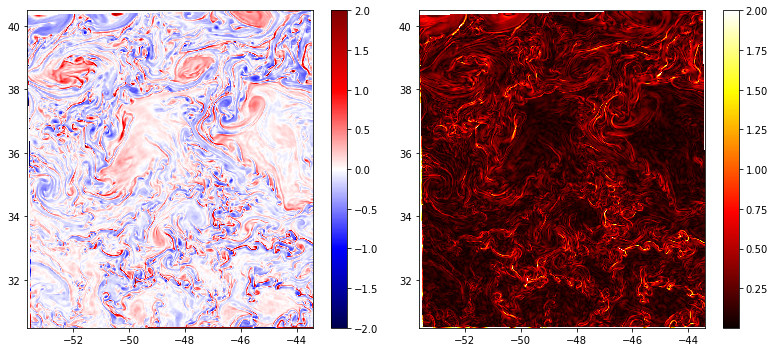

In [17]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,5))
fig.set_tight_layout(True)

im1 = ax1.pcolormesh(enatl02w.lon, enatl02w.lat, vorenatlw.isel(time_counter=0)/enatlf, 
                     cmap='seismic', vmax=2, vmin=-2, rasterized=True)
im2 = ax2.pcolormesh(enatl02w.lon, enatl02w.lat, strenatlw.isel(time_counter=0)/enatlf, 
                     cmap='hot', vmax=2, rasterized=True)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)

In [57]:
gigatl02w = gigatl_datasets["Region02/surf/fma"].isel(time=np.arange(0,2280,12)
                                                     ).chunk({'xi_u':200,'eta_rho':200,
                                                              'xi_rho':200,'eta_v':200})
gridg = gigatl02w.attrs["xgcm-Grid"]

mask_rho = gigatl02w.salt.where(gigatl02w.salt==0.).isel(time=0)
mask_u = gridg.interp(mask_rho, 'xi')
mask_v = gridg.interp(mask_rho, 'eta')
mask_psi = gridg.interp(gridg.interp(mask_rho, 'eta'), 'xi')
gigaf = gridg.interp(gridg.interp(gigatl02w.f, 'eta'), 'xi')

pm_psi = gridg.interp(gridg.interp(gigatl02w.pm, 'eta'), 'xi') # at psi points (eta_v, xi_u) 
pn_psi = gridg.interp(gridg.interp(gigatl02w.pn, 'xi'), 'eta') # at psi points (eta_v, xi_u)

dudy = gridg.diff(gigatl02w.u.where(mask_u!=0.), 'eta') * pn_psi
dudx = gridg.diff(gigatl02w.u.where(mask_u!=0.), 'xi', boundary='extend') * gigatl02w.pm
dvdx = gridg.diff(gigatl02w.v.where(mask_v!=0.), 'xi') * pm_psi
dvdy = gridg.diff(gigatl02w.v.where(mask_v!=0.), 'eta', boundary='extend') * gigatl02w.pn

# gigaf.plot()
# mask_psi = gridg.interp(gridg.interp(gigatl01w.mask_rho, 'eta'), 'xi') # at psi points (eta_v, xi_u) 

vorgigaw = (dvdx - dudy).rename('vort')
strgigaw = np.sqrt(gridg.interp(gridg.interp((dudx - dvdy)**2,'xi'),'eta') + (dudy + dvdx)**2).rename('strain')
strgigaw

,Array,Chunk
Bytes,1.43 GB,310.47 kB
Shape,"(190, 1410, 1330)","(2, 197, 197)"
Count,2138688 Tasks,79515 Chunks
Type,float32,numpy.ndarray


In [58]:
gigatl02s = gigatl_datasets["Region02/surf/aso"].isel(time=np.arange(0,2280,12)
                                                     ).chunk({'xi_u':200,'eta_rho':200,
                                                              'xi_rho':200,'eta_v':200})
gridg = gigatl02s.attrs["xgcm-Grid"]


# pm_psi = gridg.interp(gridg.interp(gigatl01s.pm, 'eta'), 'xi') # at psi points (eta_v, xi_u) 
# pn_psi = gridg.interp(gridg.interp(gigatl01s.pn, 'xi'), 'eta') # at psi points (eta_v, xi_u)

dudy = gridg.diff(gigatl02s.u.where(mask_u!=0.), 'eta') * pn_psi
dudx = gridg.diff(gigatl02s.u.where(mask_u!=0.), 'xi', boundary='extend') * gigatl02s.pm
dvdx = gridg.diff(gigatl02s.v.where(mask_v!=0.), 'xi') * pm_psi
dvdy = gridg.diff(gigatl02s.v.where(mask_v!=0.), 'eta', boundary='extend') * gigatl02s.pn

# f_psi = gridg.interp(gridg.interp(gigatl01s.f, 'eta'), 'xi')
# mask_psi = gridg.interp(gridg.interp(gigatl01s.mask_rho, 'eta'), 'xi') # at psi points (eta_v, xi_u) 

vorgigas = (dvdx - dudy).rename('vort')
strgigas = np.sqrt(gridg.interp(gridg.interp((dudx - dvdy)**2,'xi'),'eta') + (dudy + dvdx)**2).rename('strain')
strgigas

,Array,Chunk
Bytes,1.43 GB,310.47 kB
Shape,"(190, 1410, 1330)","(2, 197, 197)"
Count,2138916 Tasks,79515 Chunks
Type,float32,numpy.ndarray


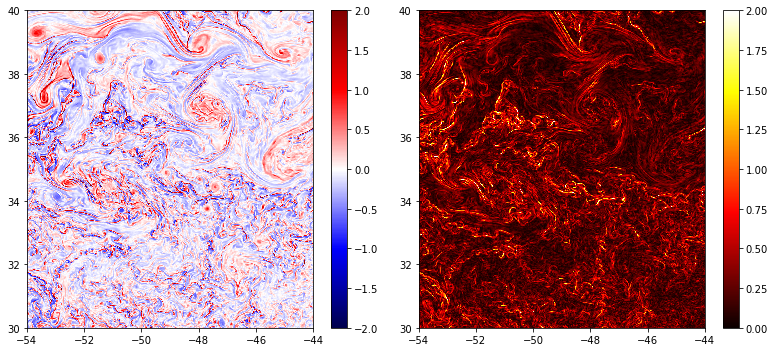

In [24]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,5))
fig.set_tight_layout(True)

im1 = ax1.pcolormesh(gigatl02w.lon, gigatl02w.lat, vorgigaw.where(mask_psi!=0.).isel(time=0)/gigaf,
                     cmap='seismic', vmax=2, vmin=-2, rasterized=True)
im2 = ax2.pcolormesh(gigatl02w.lon, gigatl02w.lat, strgigaw.where(mask_psi!=0.).isel(time=0)/gigaf, 
                     cmap='hot', vmax=2, vmin=0., rasterized=True)

ax1.set_xlim([-54,-44])
ax1.set_ylim([30,40])
ax2.set_xlim([-54,-44])
ax2.set_ylim([30,40])

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)

In [17]:
vorllcw = ((gridllc.diff(llc02w.V[::12] * llc02w.dyC,'X',boundary='fill') 
             - gridllc.diff(llc02w.U[::12] * llc02w.dxC,'Y',boundary='fill')
            ) / llc02w.rAz).isel(k=0).rename('vort')
divllcw = ((gridllc.diff(llc02w.V[::12] * llc02w.dxG,'Y',boundary='extend') 
            + gridllc.diff(llc02w.U[::12] * llc02w.dyG,'X',boundary='extend')
           ) / llc02w.rA).isel(k=0).rename('div')
strllcw = np.sqrt(gridllc.interp(gridllc.interp(((gridllc.diff(llc02w.U[::12] * llc02w.dyG,'X',boundary='fill') 
                                                  - gridllc.diff(llc02w.V[::12] * llc02w.dxG,'Y',boundary='fill')
                                                 ) / llc02w.rA)**2,
                                                'Y',boundary='fill'),
                                 'X',boundary='fill').isel(k=0)
                  + ((gridllc.diff(llc02w.U[::12] * llc02w.dxC,'Y',boundary='fill') 
                      + gridllc.diff(llc02w.V[::12] * llc02w.dyC,'X',boundary='fill') 
                     ) / llc02w.rAz).isel(k=0)**2
                 ).rename('strain')
strllcw

<xarray.DataArray 'strain' (time: 180, j_g: 321, i_g: 242)>
dask.array<sqrt, shape=(180, 321, 242), dtype=float32, chunksize=(1, 319, 240), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2012-02-01 ... 2012-04-30T12:00:00
    k        int64 0
  * j_g      (j_g) int64 4778 4779 4780 4781 4782 ... 5094 5095 5096 5097 5098
  * i_g      (i_g) int64 8255 8256 8257 8258 8259 ... 8492 8493 8494 8495 8496
    rAz      (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    XG       (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    YG       (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    dxV      (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    dyU      (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>

In [18]:
tmp_path = f'{SCRATCH}/region02/LLC4320/'+f'Vort-str-div_fma.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
dsave = vorllcw.to_dataset(name='vort')
dsave['strain'] = strllcw
dsave['div'] = divllcw
dsave.reset_coords(drop=True).chunk({'j_g':100,'j':100,
                                     'i_g':100,'i':100}).to_zarr(store_tmp, mode='w')
dsave.close()

gcs://meom-ige-scratch/roxyboy/region02/LLC4320/Vort-str-div_fma.zarr


In [19]:
vorllcs = ((gridllc.diff(llc02s.V[::12] * llc02s.dyC,'X',boundary='fill') 
             - gridllc.diff(llc02s.U[::12] * llc02s.dxC,'Y',boundary='fill')
            ) / llc02s.rAz).isel(k=0).rename('vort')
divllcs = ((gridllc.diff(llc02s.V[::12] * llc02s.dxG,'Y',boundary='extend') 
            + gridllc.diff(llc02s.U[::12] * llc02s.dyG,'X',boundary='extend')
           ) / llc02s.rA).isel(k=0).rename('div')
strllcs = np.sqrt(gridllc.interp(gridllc.interp(((gridllc.diff(llc02s.U[::12] * llc02s.dyG,'X',boundary='fill') 
                                                  - gridllc.diff(llc02s.V[::12] * llc02s.dxG,'Y',boundary='fill')
                                                 ) / llc02s.rA)**2 ,
                                                'Y',boundary='fill'),
                                 'X',boundary='fill').isel(k=0) 
                  + ((gridllc.diff(llc02s.U[::12] * llc02s.dxC,'Y',boundary='fill') 
                      + gridllc.diff(llc02s.V[::12] * llc02s.dyC,'X',boundary='fill') 
                     ) / llc02s.rAz).isel(k=0)**2
                 ).rename('strain')
strllcs

<xarray.DataArray 'strain' (time: 184, j_g: 321, i_g: 242)>
dask.array<sqrt, shape=(184, 321, 242), dtype=float32, chunksize=(1, 319, 240), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-08-01 ... 2011-10-31T12:00:00
    k        int64 0
  * j_g      (j_g) int64 4778 4779 4780 4781 4782 ... 5094 5095 5096 5097 5098
  * i_g      (i_g) int64 8255 8256 8257 8258 8259 ... 8492 8493 8494 8495 8496
    rAz      (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    XG       (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    YG       (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    dxV      (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>
    dyU      (j_g, i_g) float32 dask.array<chunksize=(321, 242), meta=np.ndarray>

In [20]:
tmp_path = f'{SCRATCH}/region02/LLC4320/'+f'Vort-str-div_aso.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
dsave = vorllcs.to_dataset(name='vort')
dsave['strain'] = strllcs
dsave['div'] = divllcs
dsave.reset_coords(drop=True).chunk({'j_g':100,'j':100,
                                     'i_g':100,'i':100}).to_zarr(store_tmp, mode='w')
dsave.close()

gcs://meom-ige-scratch/roxyboy/region02/LLC4320/Vort-str-div_aso.zarr


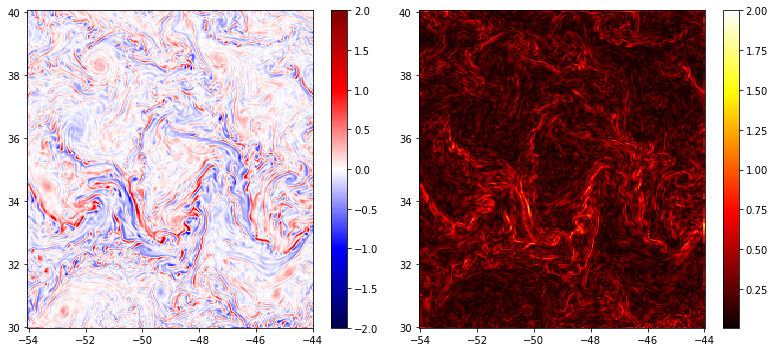

In [34]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,5))
fig.set_tight_layout(True)

im1 = ax1.pcolormesh(vorllcw.XG, vorllcw.YG, vorllcw.isel(time=0)/llcfG, cmap='seismic', vmax=2, vmin=-2)
im2 = ax2.pcolormesh(strllcw.XG, strllcw.YG, strllcw.isel(time=0)/llcfG, cmap='hot', vmax=2)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)

In [35]:
hycom02w = hycom50_datasets["Region02_GE/surf/fma"]
Ny = len(hycom50_grids["grid_02"].lat)
Nx = len(hycom50_grids["grid_02"].lon)
import gsw
xx, yy = np.meshgrid(hycom50_grids["grid_02"].longitude, hycom50_grids["grid_02"].latitude)
dx = xr.DataArray(gsw.distance(xx, yy), dims=['lat','lon'],
                  coords={'lat':np.arange(615),'lon':np.arange(.5,502,1)}
                 ).interp(lon=np.arange(503), method="linear",
                          kwargs={"fill_value": "extrapolate"})
dy = xr.DataArray(gsw.distance(xx, yy, axis=0), dims=['lat','lon'],
                  coords={'lat':np.arange(.5,614,1),'lon':np.arange(503)}
                 ).interp(lat=np.arange(615), method="linear",
                          kwargs={"fill_value": "extrapolate"})

hycom02w.coords['dx'] = (('lat','lon'), dx.data)
hycom02w.coords['dy'] = (('lat','lon'), dy.data)

hycom02s = hycom50_datasets["Region02_GE/surf/aso"]

hycom02s.coords['dx'] = (('lat','lon'), dx.data)
hycom02s.coords['dy'] = (('lat','lon'), dy.data)
hycom02s

<xarray.Dataset>
Dimensions:    (lat: 615, lon: 503, time: 2208)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 ... 2201 2202 2203 2204 2205 2206 2207
    dx         (lat, lon) float64 1.925e+03 1.925e+03 ... 1.702e+03 1.702e+03
    dy         (lat, lon) float64 1.926e+03 1.926e+03 ... 1.703e+03 1.703e+03
Dimensions without coordinates: lat, lon
Data variables:
    latitude   (lat) float32 dask.array<chunksize=(615,), meta=np.ndarray>
    longitude  (lon) float32 dask.array<chunksize=(503,), meta=np.ndarray>
    ssh        (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
    sss        (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
    sst        (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
    tauewd     (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
    taunwd     (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
    uu1        (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>
    vv1        (time, lat, lon) float32 dask.array<chunksize=(24, 615, 503), meta=np.ndarray>

In [36]:
hycomf = xr.apply_ufunc(gsw.f, hycom02w.latitude, dask='parallelized')

In [37]:
def diff(a, shift, axis):
    return a - np.roll(a, shift, axis)

def hycom_vort(u, v, dx, dy):
    return (
        diff(v * dy, 1, axis=-1)
        - diff(u * dx, 1, axis=-2)
    ) / (dx * dy)

def hycom_str(u, v, dx, dy):
    str1 = (diff(u * dy, 1, axis=-1)
            - diff(v * dx, 1, axis=-2)
           ) / (dy * dx)
    str2 = (diff(u * dx, 1, axis=-2)
            + diff(v * dy, 1, axis=-1)
           ) / (dy * dx)
    str1 = .25*(str1 
                + np.roll(str1,1,-1) 
                + np.roll(str1,1,-2)
                + np.roll(np.roll(str1,1,-1),1,-2)
               )
    return np.sqrt(str1**2
        + str2**2
    )

In [38]:
vorhycomw = xr.apply_ufunc(
    hycom_vort,
    hycom02w.uu1[::12], 
    hycom02w.vv1[::12], 
    hycom02w.dx, hycom02w.dy,
    input_core_dims = 4 * [['lat', 'lon']],    # 4 inputs
    output_core_dims = [['lat', 'lon']],
    output_dtypes=[hycom02w.uu1.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('vort')
strhycomw = xr.apply_ufunc(
    hycom_str,
    hycom02w.uu1[::12], 
    hycom02w.vv1[::12], 
    hycom02w.dx, hycom02w.dy,
    input_core_dims = 4 * [['lat', 'lon']],   # 4 inputs
    output_core_dims = [['lat', 'lon']],
    output_dtypes=[hycom02w.uu1.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('strain')
strhycomw

<xarray.DataArray 'strain' (time: 180, lat: 615, lon: 503)>
dask.array<transpose, shape=(180, 615, 503), dtype=float64, chunksize=(2, 615, 503), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 12 24 36 48 60 72 ... 2088 2100 2112 2124 2136 2148
Dimensions without coordinates: lat, lon

In [39]:
vorhycoms = xr.apply_ufunc(
    hycom_vort,
    hycom02s.uu1[::12], 
    hycom02s.vv1[::12], 
    hycom02s.dx, hycom02s.dy,
    input_core_dims = 4 * [['lat', 'lon']],    # 4 inputs
    output_core_dims = [['lat', 'lon']],
    output_dtypes=[hycom02s.uu1.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('vort')
strhycoms = xr.apply_ufunc(
    hycom_str,
    hycom02s.uu1[::12], 
    hycom02s.vv1[::12], 
    hycom02s.dx, hycom02s.dy,
    input_core_dims = 4 * [['lat', 'lon']],   # 4 inputs
    output_core_dims = [['lat', 'lon']],
    output_dtypes=[hycom02s.uu1.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('strain')
strhycoms

<xarray.DataArray 'strain' (time: 184, lat: 615, lon: 503)>
dask.array<transpose, shape=(184, 615, 503), dtype=float64, chunksize=(2, 615, 503), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 12 24 36 48 60 72 ... 2136 2148 2160 2172 2184 2196
Dimensions without coordinates: lat, lon

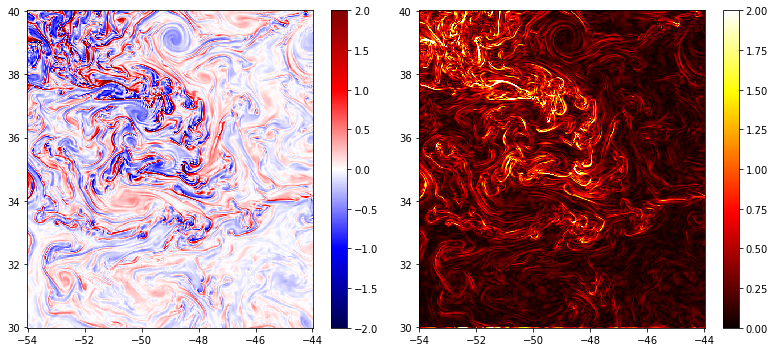

In [40]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,5))
fig.set_tight_layout(True)

im1 = ax1.pcolormesh(hycom50_grids["grid_02"].longitude, hycom50_grids["grid_02"].latitude, 
                     vorhycomw.isel(time=0)/hycomf, cmap='seismic', vmax=2, vmin=-2)
im2 = ax2.pcolormesh(hycom50_grids["grid_02"].longitude, hycom50_grids["grid_02"].latitude, 
                     strhycomw.isel(time=0)/hycomf, cmap='hot', vmin=0., vmax=2)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)

In [41]:
vbins = np.linspace(-4e0,4e0,40)
sbins = np.linspace(0,4e0,20)

In [42]:
histenatlw = xhist((strenatlw/enatlf).rename('strain').isel(y=slice(2,-2),x=slice(2,-2)).chunk({'y':-1,'x':-1}), 
                   (vorenatlw/enatlf).rename('vort').isel(y=slice(2,-2),x=slice(2,-2)).chunk({'y':-1,'x':-1}), 
                   bins=[sbins, vbins]
                  ).compute()
histenatls = xhist((strenatls/enatlf).rename('strain').isel(y=slice(2,-2),x=slice(2,-2)).chunk({'y':-1,'x':-1}), 
                   (vorenatls/enatlf).rename('vort').isel(y=slice(2,-2),x=slice(2,-2)).chunk({'y':-1,'x':-1}),  
                   bins=[sbins, vbins]
                  ).compute()

In [ ]:
histgigatlw = xhist((strgigaw/gigaf).rename('strain').isel(eta_v=slice(2,-2),
                                                           xi_u=slice(2,-2)).chunk({'eta_v':-1,'xi_u':-1}), 
                    (vorgigaw/gigaf).rename('vort').isel(eta_v=slice(2,-2),
                                                         xi_u=slice(2,-2)).chunk({'eta_v':-1,'xi_u':-1}), 
                    bins=[sbins, vbins]
                   ).compute()
histgigatls = xhist((strgigas/gigaf).rename('strain').isel(eta_v=slice(2,-2),
                                                           xi_u=slice(2,-2)).chunk({'eta_v':-1,'xi_u':-1}), 
                    (vorgigas/gigaf).rename('vort').isel(eta_v=slice(2,-2),
                                                         xi_u=slice(2,-2)).chunk({'eta_v':-1,'xi_u':-1}),  
                    bins=[sbins, vbins]
                   ).compute()

In [44]:
histhycomw = xhist((strhycomw/hycomf).rename('strain').isel(lat=slice(2,-2),
                                                            lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}), 
                   (vorhycomw/hycomf).rename('vort').isel(lat=slice(2,-2),
                                                          lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}), 
                   bins=[sbins, vbins]
                  ).compute()
histhycoms = xhist((strhycoms/hycomf).rename('strain').isel(lat=slice(2,-2),
                                                            lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}), 
                   (vorhycoms/hycomf).rename('vort').isel(lat=slice(2,-2),
                                                          lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}),  
                   bins=[sbins, vbins]
                  ).compute()

In [46]:
histllcw = xhist((strllcw/llcfG).rename('strain').isel(j_g=slice(2,-2),
                                                       i_g=slice(2,-2)).chunk({'time':10,'j_g':-1,'i_g':-1}), 
                 (vorllcw/llcfG).rename('vort').isel(j_g=slice(2,-2),
                                                     i_g=slice(2,-2)).chunk({'time':10,'j_g':-1,'i_g':-1}), 
                 bins=[sbins, vbins]
                ).compute()
histllcs = xhist((strllcs/llcfG).rename('strain').isel(j_g=slice(2,-2),
                                                       i_g=slice(2,-2)).chunk({'time':10,'j_g':-1,'i_g':-1}),
                 (vorllcs/llcfG).rename('vort').isel(j_g=slice(2,-2),
                                                     i_g=slice(2,-2)).chunk({'time':10,'j_g':-1,'i_g':-1}),  
                 bins=[sbins, vbins]
                ).compute()

In [ ]:
fig, axes = plt.subplots(figsize=(15,14), nrows=4, ncols=3)
# fig.set_tight_layout(True)
ax00 = axes[0,0]
ax01 = axes[0,1]
ax02 = axes[0,2]
ax10 = axes[1,0]
ax11 = axes[1,1]
ax12 = axes[1,2]
ax20 = axes[2,0]
ax21 = axes[2,1]
ax22 = axes[2,2]
ax30 = axes[3,0]
ax31 = axes[3,1]
ax32 = axes[3,2]


im0 = ax00.pcolormesh(histenatlw.vort_bin,
                      histenatlw.strain_bin,
                      histenatlw, 
                      cmap='Blues', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
                      rasterized=True)
ax10.pcolormesh(histhycomw.vort_bin,
                histhycomw.strain_bin,
                histhycomw, 
                cmap='Blues', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
                rasterized=True)
ax20.pcolormesh(histgigatlw.vort_bin,
                histgigatlw.strain_bin,
                histgigatlw,
                cmap='Blues', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
                rasterized=True)
ax30.pcolormesh(histllcw.vort_bin,
                histllcw.strain_bin,
                histllcw,
                cmap='Blues', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
                rasterized=True)

im1 = ax01.pcolormesh(histenatls.vort_bin,
                      histenatls.strain_bin,
                      histenatls,
                      cmap='Reds', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
                      rasterized=True)
ax11.pcolormesh(histhycoms.vort_bin,
                histhycoms.strain_bin,
                histhycoms,
                cmap='Reds', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
                rasterized=True)
ax21.pcolormesh(histgigatls.vort_bin,
                histgigatls.strain_bin,
                histgigatls,  
                cmap='Reds', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
                rasterized=True)
ax31.pcolormesh(histllcs.vort_bin,
                histllcs.strain_bin,
                histllcs,  
                cmap='Reds', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
                rasterized=True)

im2 = ax02.pcolormesh(histenatlw.vort_bin,
                      histenatlw.strain_bin, 
                      (histenatlw
                       / histenatls), 
                      cmap='RdBu_r', norm=clr.LogNorm(vmin=1e-2, vmax=1e2), 
                      rasterized=True)
ax12.pcolormesh(histhycomw.vort_bin,
                histhycomw.strain_bin, 
                (histhycomw
                 / histhycoms), 
                cmap='RdBu_r', norm=clr.LogNorm(vmin=1e-2, vmax=1e2), 
                rasterized=True)
ax22.pcolormesh(histgigatlw.vort_bin,
                histgigatlw.strain_bin, 
                (histgigatlw
                 / histgigatls), 
                cmap='RdBu_r', norm=clr.LogNorm(vmin=1e-2, vmax=1e2), 
                rasterized=True)
ax32.pcolormesh(histllcw.vort_bin,
                histllcw.strain_bin, 
                (histllcw
                 / histllcs), 
                cmap='RdBu_r', norm=clr.LogNorm(vmin=1e-2, vmax=1e2), 
                rasterized=True)


ax00.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax00.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax01.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax01.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax02.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax02.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax10.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax10.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax11.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax11.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax12.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax12.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax20.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax20.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax21.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax21.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax22.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax22.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax30.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax30.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax31.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax31.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax32.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax32.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')


ax00.set_xlim([-4,4])
ax01.set_xlim([-4,4])
ax02.set_xlim([-4,4])
ax10.set_xlim([-4,4])
ax11.set_xlim([-4,4])
ax12.set_xlim([-4,4])
ax20.set_xlim([-4,4])
ax21.set_xlim([-4,4])
ax22.set_xlim([-4,4])
ax30.set_xlim([-4,4])
ax31.set_xlim([-4,4])
ax32.set_xlim([-4,4])
ax00.set_ylim([0,4])
ax01.set_ylim([0,4])
ax02.set_ylim([0,4])
ax10.set_ylim([0,4])
ax11.set_ylim([0,4])
ax12.set_ylim([0,4])
ax20.set_ylim([0,4])
ax21.set_ylim([0,4])
ax22.set_ylim([0,4])
ax30.set_ylim([0,4])
ax31.set_ylim([0,4])
ax32.set_ylim([0,4])

ax30.set_xlabel(r"$\zeta/f$", fontsize=13)
ax31.set_xlabel(r"$\zeta/f$", fontsize=13)
ax32.set_xlabel(r"$\zeta/f$", fontsize=13)
ax00.set_ylabel(r"eNATL60 $|\alpha|/f$", fontsize=13)
ax10.set_ylabel(r"HYCOM50 $|\alpha|/f$", fontsize=13)
ax20.set_ylabel(r"GIGATL $|\alpha|/f$", fontsize=13)
ax30.set_ylabel(r"LLC4320 $|\alpha|/f$", fontsize=13)

ax00.grid(True)
ax01.grid(True)
ax02.grid(True)
ax10.grid(True)
ax11.grid(True)
ax12.grid(True)
ax20.grid(True)
ax21.grid(True)
ax22.grid(True)
ax30.grid(True)
ax31.grid(True)
ax32.grid(True)

fig.subplots_adjust(bottom=.172, hspace=.2) 
cbax0 = fig.add_axes([0.14, 0.12, 0.2, 0.013])
cbar0 = fig.colorbar(im0, orientation='horizontal', cax=cbax0)
cbar0.set_label(r"Winter", fontsize=12)

cbax1 = fig.add_axes([0.415, 0.12, 0.2, 0.013])
cbar1 = fig.colorbar(im1, orientation='horizontal', cax=cbax1)
cbar1.set_label(r"Summer", fontsize=12)

cbax2 = fig.add_axes([0.69, 0.12, 0.2, 0.013])
cbar2 = fig.colorbar(im2, orientation='horizontal', cax=cbax2)
cbar2.set_label(r"Winter/Summer", fontsize=12)

plt.savefig('/home/jovyan/Figures/vort-strain-jointPDF_02.pdf')

In [ ]:
client.close()